In [1]:
# Importing modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Initialising value
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
DIRECTORY = r'D:\ps'
CATEGORIES = ['with_mask', 'without_mask']
data = []
labels = []

In [4]:
# Reading datasets and converting to array
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size= (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

In [5]:
# Converting the labels into binary
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype='float32')
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state= 42)

In [6]:
# Increasing dataset by augmentation
aug = ImageDataGenerator(
    rotation_range= 20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

In [7]:
#base model by MobileNet
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_tensor= Input(shape=(224,224,3)))

#head of the model place on top of base model 
headModel = baseModel.output 
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name='flattern')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs = baseModel.input, outputs = headModel)

#freezing the baseModel so that weight will not updated 
for layer in baseModel.layers:
    layer.trainable = False

In [8]:
# Compiling and training
opt = Adam(lr = INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
             steps_per_epoch= len(trainX) // BS,
             validation_data=(testX, testY),
             validation_steps=len(testX) // BS,
             epochs = EPOCHS,)

Epoch 1/20
48/48 [==============================] - 49s 1s/step - loss: 0.3162 - accuracy: 0.8665 - val_loss: 0.0366 - val_accuracy: 0.9974
Epoch 2/20
48/48 [==============================] - 52s 1s/step - loss: 0.0655 - accuracy: 0.9810 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 3/20
48/48 [==============================] - 47s 977ms/step - loss: 0.0371 - accuracy: 0.9908 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 4/20
48/48 [==============================] - 50s 1s/step - loss: 0.0259 - accuracy: 0.9935 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 5/20
48/48 [==============================] - 53s 1s/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 6/20
48/48 [==============================] - 51s 1s/step - loss: 0.0165 - accuracy: 0.9974 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/20
48/48 [==============================] - 50s 1s/step - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 8/20
48/48 

In [9]:
# Predicting the model
predIdxs = model.predict(testX, batch_size = BS)

# each testing image finding largest index label probability 
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs, target_names = lb.classes_))

model.save('mask_detector.model', save_format='h5')

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       190
without_mask       1.00      1.00      1.00       200

    accuracy                           1.00       390
   macro avg       1.00      1.00      1.00       390
weighted avg       1.00      1.00      1.00       390



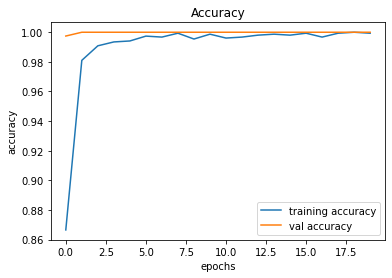

In [16]:
# Ploting accuracy
plt.figure(0)
plt.plot(H.history['accuracy'], label='training accuracy')
plt.plot(H.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

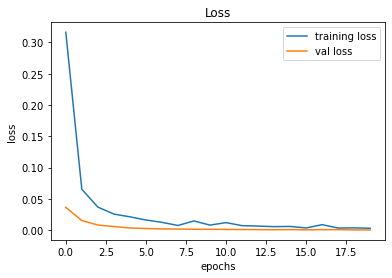

In [14]:
# Ploting loss
plt.plot(H.history['loss'], label= 'training loss')
plt.plot(H.history['val_loss'], label= 'val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()